![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/18.ViT_for_Image_Classification.ipynb)

# ViT for Image Classification with Transformers

## Install Spark NLP

In [ ]:
!wget -q https://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.2.1 -s 4.1.0

In [1]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark = sparknlp.start()
spark

## 1. ViTForImageClassification Annotator

The Vision Transformer (ViT) model was proposed in ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/pdf/2010.11929.pdf) written by Alexey Dosovitskiy et al. in 2021. It is the first paper that successfully trains a Transformer encoder on ImageNet, attaining very good results compared to familiar convolutional architectures.  

When pre-trained on large amounts of data and transferred to multiple mid-sized or small image recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.  

Inspired by the Transformer scaling successes in NLP, the researchers experimented with applying a standard Transformer directly to images, with the fewest possible modifications. To do so,  images are split into patches and the sequence of linear embeddings of these patches were provided as an input to a  Transformer. Image patches were actually treated the same way as tokens (words) in an NLP application. Image classification models were trained in supervised fashion.  

You can check [Scale Vision Transformers (ViT) Beyond Hugging Face](https://hackernoon.com/scale-vision-transformers-vit-beyond-hugging-face) article to learn deeper how ViT works and how it is implemeted in Spark NLP.

 


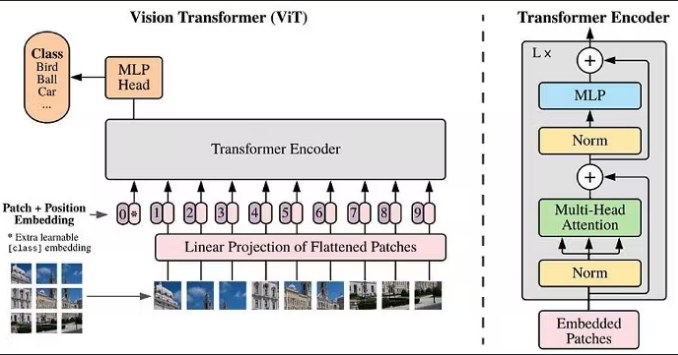






## Spark NLP vs HuggingFace Benchmarks


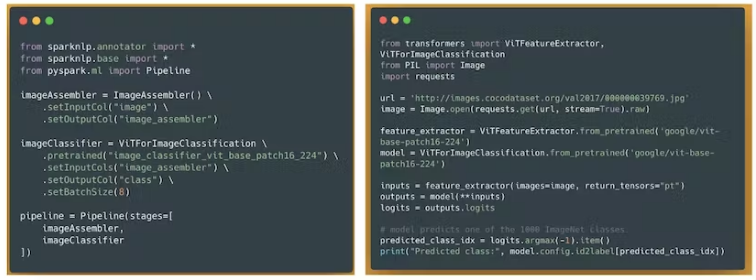


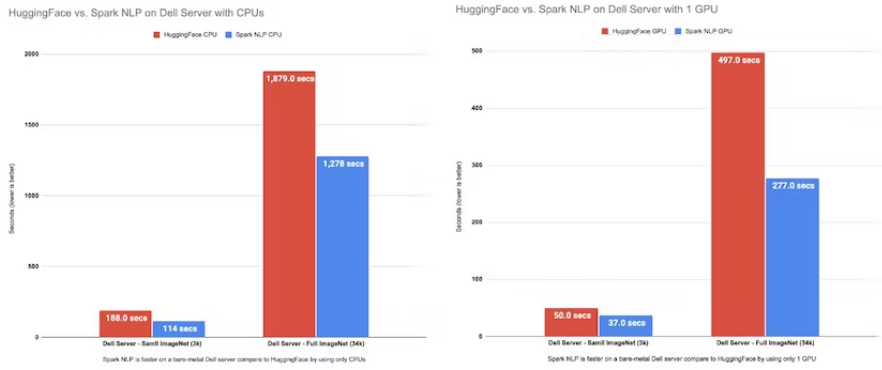

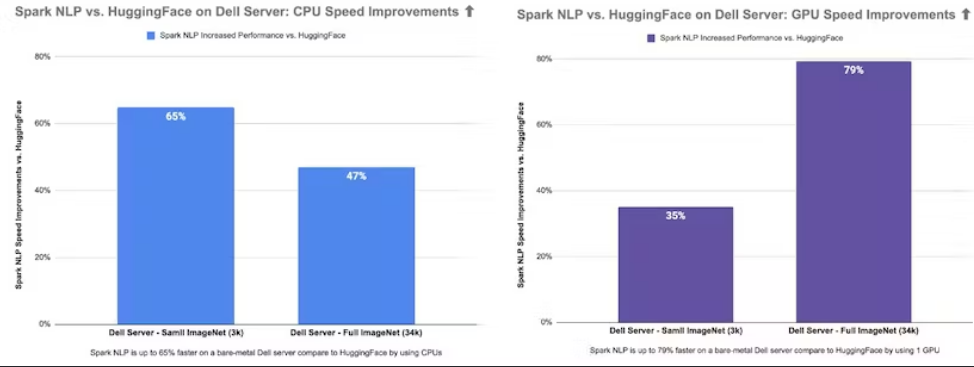

You can find all ViT models and more in [NLP Models Hub](https://nlp.johnsnowlabs.com/models?q=ViT&type=model&task=Image+Classification).

## 2. Additional blogposts and videos:


*   [Vision Transformer (ViT) - Hugging Face](https://huggingface.co/docs/transformers/model_doc/vit)
*   [Vision Transformers (ViT) in Image Recognition – 2022 Guide](https://viso.ai/deep-learning/vision-transformer-vit/)
*   [Image Classification using Huggingface ViT | by Kenji Tee](https://medium.com/@kenjiteezhen/image-classification-using-huggingface-vit-261888bfa19f)
*   [Vision Transformer for Image Classification - Video](https://www.youtube.com/watch?v=HZ4j_U3FC94)
*   [Using Transformers for Image Classification | HuggingFace - Video](https://www.youtube.com/watch?v=Bjp7hebC67E)







## 3. Download Images

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/images/images.zip

In [6]:
import shutil
shutil.unpack_archive("images.zip", "images", "zip")

## 4. Pipeline with ViTForImageClassification

In [2]:
data_df = spark.read.format("image").option("dropInvalid", value = True).load(path="/content/images/images/")

In [3]:
image_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

image_classifier = ViTForImageClassification \
    .pretrained() \
    .setInputCols("image_assembler") \
    .setOutputCol("classes")

pipeline = Pipeline(stages=[
    image_assembler,
    image_classifier,
])

model = pipeline.fit(data_df)

image_classifier_vit_base_patch16_224 download started this may take some time.
Approximate size to download 309.7 MB
[OK!]


In [4]:
# lets check the counts of classes in this model

len(image_classifier.getClasses())

999

Lets transform the data.

In [5]:
image_df = model.transform(data_df)

In [6]:
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- image_assembler: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- origin: string (nullable = true)
 |    |    |-- height: integer (nullable = false)
 |    |    |-- width: integer (nullable = false)
 |    |    |-- nChannels: integer (nullable = false)
 |    |    |-- mode: integer (nullable = false)
 |    |    |-- result: binary (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |-- classes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorTyp

In [7]:
image_df.show(truncate=40)

+----------------------------------------+----------------------------------------+----------------------------------------+
|                                   image|                         image_assembler|                                 classes|
+----------------------------------------+----------------------------------------+----------------------------------------+
|{file:///content/images/images/palace...|[{image, file:///content/images/image...|[{category, 0, 5, palace, {nChannels ...|
|{file:///content/images/images/egypti...|[{image, file:///content/images/image...|[{category, 0, 11, Egyptian cat, {nCh...|
|{file:///content/images/images/hippop...|[{image, file:///content/images/image...|[{category, 0, 55, hippopotamus, hipp...|
|{file:///content/images/images/hen.JP...|[{image, file:///content/images/image...|[{category, 0, 2, hen, {nChannels -> ...|
|{file:///content/images/images/ostric...|[{image, file:///content/images/image...|[{category, 0, 24, ostrich, Struthio ...|


Now we can check the classes. 

In [8]:
image_df.select('classes').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|classes                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [9]:
image_df.select(F.explode(F.arrays_zip(image_df.classes.metadata, 
                                       image_df.classes.result)).alias("cols"))\
        .select(F.expr("cols['0']['origin']").alias("images"),
                F.expr("cols['0']['width']").alias("width"),
                F.expr("cols['0']['height']").alias("height"),
                F.expr("cols['1']").alias("class")).show(truncate=False)

+-----------------------------------------------+-----+------+--------------------------------------------------------+
|images                                         |width|height|class                                                   |
+-----------------------------------------------+-----+------+--------------------------------------------------------+
|file:///content/images/images/palace.JPEG      |500  |334   |palace                                                  |
|file:///content/images/images/egyptian_cat.jpeg|640  |480   |Egyptian cat                                            |
|file:///content/images/images/hippopotamus.JPEG|500  |333   |hippopotamus, hippo, river horse, Hippopotamus amphibius|
|file:///content/images/images/hen.JPEG         |500  |375   |hen                                                     |
|file:///content/images/images/ostrich.JPEG     |300  |400   |ostrich, Struthio camelus                               |
|file:///content/images/images/junco.JPE

## 5. Light Pipeline

To use light pipeline in ViT transformer, we need to use the new method [`fullAnnotateImage`](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/base/light_pipeline/index.html).

In [11]:
light_pipeline = LightPipeline(model)

image_list = ["/content/images/images/bluetick.jpg", "/content/images/images/palace.JPEG", "/content/images/images/hen.JPEG"]
annotations_result = light_pipeline.fullAnnotateImage(image_list)
annotations_result[0].keys()

dict_keys(['image_assembler', 'classes'])

In [12]:
import pandas as pd

file_name = []
classes = []

for i in annotations_result:

    file_name.append(i["image_assembler"][0].origin.split("/")[-1])
    classes.append(i["classes"][0].result) 
    

df_images = pd.DataFrame({'file':file_name,
                          'class':classes})

df_images

,file,class
0,bluetick.jpg,bluetick
1,palace.JPEG,palace
2,hen.JPEG,hen
